In [40]:
pip install d2spy leafmap 

Note: you may need to restart the kernel to use updated packages.


In [1]:
from datetime import date

from d2spy.workspace import Workspace

import os

import leafmap

In [2]:
# Connect to Purdue hosted D2S instance. It will prompt for your D2S password.
workspace = Workspace.connect("https://ps2.d2s.org", "jgillan@arizona.edu")

In [3]:
# Get list of all your projects
projects = workspace.get_projects()

# Check if there are any projects
if len(projects) > 0:
    # Loop through all projects and print each one
    for project in projects:
        print(f"ID: {project.id}")
        print(f"Title: {project.title}")
        print(f"Description: {project.description}\n")
else:
    print("Please create a project before proceeding with this guide.")


ID: ace74e20-ceec-45cd-b260-2a0f1c50b420
Title: Holiday Beach
Description: After Hurricane Harvey Survey

ID: 91509636-98e7-4e2c-9a68-e9006846b52f
Title: Purdue PUSH
Description: Purdue University Student Health Service building

ID: c15b0825-6e74-4899-b6bd-2917ce1ae3bd
Title: OsaLarge
Description: Large area including the Osa Conservation base camp.

ID: 77a769b0-61af-4813-894a-746001759f67
Title: Biosphere 2
Description: UAS Summit On Open Science & Data Management

ID: 2f939aa4-95e0-4b33-b0bb-e144207044ab
Title: Santa Rita Experimental Range
Description: Drone Imagery from 2019 collection

ID: 62773825-5d03-4eb0-8439-a463c0e09b0b
Title: Cornell Wheat - 2023
Description: T3 <-> UASHUB

ID: 2f27061b-2d66-41bd-9fd5-fc038ad34496
Title: Peanut Demo
Description: Demonstrating cloud data processing example

ID: fbac2a0a-1c7f-4add-b276-0c2a6644711a
Title: Paradise Valley Country Club
Description: Topographic surveying of the golf course for the purpose of installing subsurface drip irrigati

In [4]:
###Choose a project (from the previous print) and list all flights for that project

# Define the project ID you're looking for
project_id = "46669dd1-3c9a-487e-adaa-92dd50bf0420"

# Find the project by ID
selected_project = None
for project in projects:
    if project.id == project_id:
        selected_project = project
        break

# Check if the project was found
if selected_project:
    # Get list of all flights for the selected project
    flights = selected_project.get_flights()

    # Check if there are any flights
    if len(flights) > 0:
        # Loop through all flights and print each one
        for flight in flights:
            print(flight)
    else:
        print("No flights found for this project.")
else:
    print(f"Project with ID '{project_id}' not found.")

Flight(acquisition_date='2020-11-17', name='welltonfw', altitude=18.0, side_overlap=60.0, forward_overlap=75.0, sensor='RGB', platform='Phantom_4')


In [5]:
# Get list of data products from a flight. O in this case is the first flight listed.
data_products = flights[0].get_data_products()

# Check if there are any data products
if len(data_products) > 0:
    # Loop through all data products and print their URLs
    for product in data_products:
        print(product.url)
else:
    print("No data products found for this flight.")


https://ps2.d2s.org/static/projects/46669dd1-3c9a-487e-adaa-92dd50bf0420/flights/72e1b4a1-68ea-48bf-85d1-4f6315cd78bd/data_products/fcb09a00-181c-4e3c-ba89-e58c7e7a7223/3ac72e63-64fe-4713-af0b-c332b3851032.tif
https://ps2.d2s.org/static/projects/46669dd1-3c9a-487e-adaa-92dd50bf0420/flights/72e1b4a1-68ea-48bf-85d1-4f6315cd78bd/data_products/0a8c3e32-b649-4d48-ae6d-892126e7933b/f6f8a1a4-ac0f-4fe5-b37e-8b57c00c3d80.tif


In [6]:
os.environ["TITILER_ENDPOINT"] = "https://tt.d2s.org"

In [7]:
# Interactive leafmap Map
m = leafmap.Map()

# URL for a D2S hosted GeoTIFF data product
ortho_url = "https://ps2.d2s.org/static/projects/46669dd1-3c9a-487e-adaa-92dd50bf0420/flights/72e1b4a1-68ea-48bf-85d1-4f6315cd78bd/data_products/fcb09a00-181c-4e3c-ba89-e58c7e7a7223/3ac72e63-64fe-4713-af0b-c332b3851032.tif"

# Add a publicly available data product to the map
m.add_cog_layer(ortho_url, name="Orthomosaic")

# If you want to display a private data product, comment out the previously line and uncomment the below m.add_cog_layer line
# Add a private data product to the map
# m.add_cog_layer(f"{ortho_url}?API_KEY={api_key}", name="DSM", colormap_name="rainbow")

# Display the map
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [8]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import requests
import numpy as np

In [9]:
##Get some basic information about the COG

with rasterio.open(ortho_url) as dataset:
    # Now you can work with the dataset, e.g., read out specific bands, metadata, etc.
    print(dataset.profile)  # Print the dataset profile, like CRS, bounds, etc.

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 10724, 'height': 25105, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(0.008, 0.0, 768488.1780000001,
       0.0, -0.008, 3621649.67699), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


In [10]:
# Is it a COG?

with rasterio.open(ortho_url) as src:
    # Check for internal tiling
    tiled = src.is_tiled
    print(f"Tiled: {tiled}")

    # Check for overviews
    overviews = src.overviews(1)  # Checks overviews for the first band
    has_overviews = len(overviews) > 0
    print(f"Has Overviews: {has_overviews}")

Tiled: True
Has Overviews: True


In [ ]:
##Read in and display the entire COG. Large files require a lot of memory usage.

with rasterio.open(ortho_url) as dataset:
    # Read the entire dataset
    # This reads all bands; if the dataset is multi-band, they will be read into a 3D array
    data = dataset.read()


In [8]:
#Import necessary modules from Detecto python library
from detecto.core import Model #bring in the Faster R-CNN ResNet50 FPM model
from detecto.utils import read_image
from detecto.visualize import show_labeled_image

In [12]:
#Download the fine-tuned model from Hugging Face
!wget https://huggingface.co/jgillan/phytooracle_lettuce_1/resolve/main/detecto_heatmap_lettuce_detection_weights.pth


--2024-10-18 14:00:52--  https://huggingface.co/jgillan/phytooracle_lettuce_1/resolve/main/detecto_heatmap_lettuce_detection_weights.pth
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.118, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/14/8d/148def09b410f4ca5e9d2111f480c1ff54b4280c92f1f3dd77e1d821319f4153/5fd3940b4b9d9fbed3efa0ac39e3865252d80be69888ddf8404b44af9a5f9866?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27detecto_heatmap_lettuce_detection_weights.pth%3B+filename%3D%22detecto_heatmap_lettuce_detection_weights.pth%22%3B&Expires=1729544452&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyOTU0NDQ1Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzE0LzhkLzE0OGRlZjA5YjQxMGY0Y2E1ZTlkMjExMWY0ODBjMWZmNTRiNDI4MGM5MmYxZjNkZDc3ZTFkODIxMzE5ZjQxNTMvNWZkM

In [9]:
image = read_image('/Users/jgillan/Downloads/yuma_lettuce.tif') #read in the image

In [18]:
labels = [
    'romaine',
    'leaf lettuce'
]

In [19]:
#model = Model() #bring in detecto's pre-trained general model
model = Model.load('detecto_heatmap_lettuce_detection_weights.pth', labels) #load the fine-tuned model
labels, boxes, scores = model.predict(image)


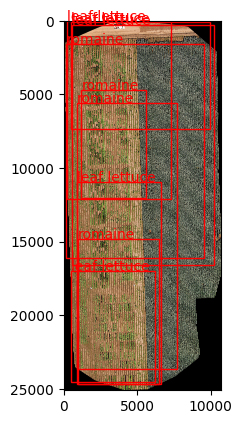

In [15]:
show_labeled_image(image, boxes, labels) #display the image with the bounding boxes and labels

In [ ]:
# Removes access token from future requests
workspace.logout()